In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import seaborn as sns
from progressbar import ProgressBar
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

np.random.seed(42)

%matplotlib inline

Using TensorFlow backend.


In [2]:
df_train = pd.read_csv(join('..', '..', 'input', 'train_v2.csv'))

df_train = pd.concat([df_train['image_name'], df_train.tags.str.get_dummies(sep=' ')], axis=1)
all_labels = df_train.columns[1:].tolist()

df_labels = df_train[all_labels]

cifar10_norm = False
std_multi = 1

In [3]:
# Normalization applied to the images
if cifar10_norm:
    means_per_channel = np.array([ 123.68, 116.779, 103.939], dtype=np.float32)
    stds_per_channel  = np.array([ 1, 1, 1], dtype=np.float32)
    std_multi = 1.
else:
    means_per_channel = np.array([ 77.95814168, 85.57786945, 75.08671441], dtype=np.float32)
    stds_per_channel  = np.array([ 41.65053961, 35.81152416, 34.00985153], dtype=np.float32) / std_multi


In [4]:
from skimage.io import imread
tif_folder = '../../input/train-tif-v2'
jpg_folder = '../../input/train-jpg'

norm = lambda im: (im - means_per_channel) / stds_per_channel
denorm = lambda im: ((im * stds_per_channel) + means_per_channel).clip(0, 255).astype(np.uint8)

load_jpg = lambda f: norm(imread(join(jpg_folder, f + '.jpg')))
load_jpg_mean = lambda f: load_jpg(f).mean(axis=(0, 1))

In [5]:
# Load images
n_samples = 5000

imgs_names = df_train.image_name.sample(n_samples, random_state=42, replace=False)

bar = ProgressBar()
mean_colors = map(load_jpg_mean, bar(imgs_names))

mean_colors = np.array(mean_colors)

print(mean_colors.shape)

100% (5000 of 5000) |######################################################################################################################################################################################################################| Elapsed Time: 0:00:24 Time: 0:00:24


(5000, 3)


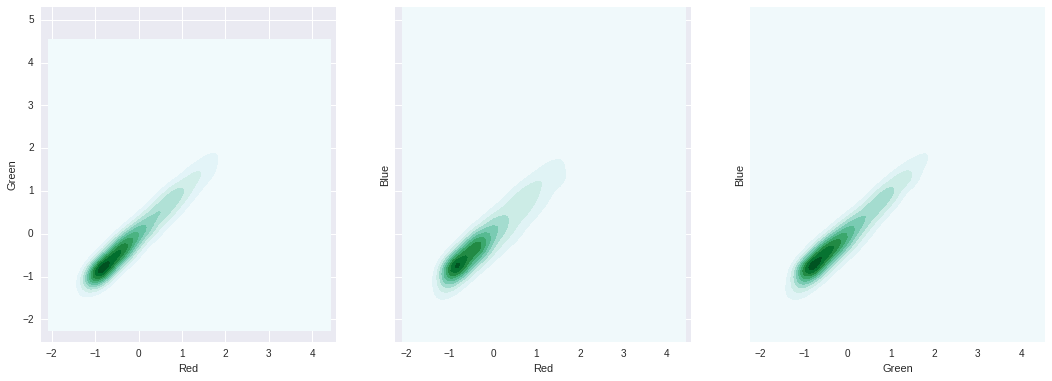

In [6]:
from itertools import combinations

axis_names = ['Red', 'Green', 'Blue']

axis_combs = list(combinations(range(len(axis_names)), 2))

fig, ax = plt.subplots(1, len(axis_combs), figsize=(18, 6), sharex=True, sharey=True)
ax = ax.ravel()

for i, (ax0, ax1) in enumerate(axis_combs):
    #ax[i].scatter(mean_colors[:, ax0], mean_colors[:, ax1], alpha=0.01)
    sns.kdeplot(mean_colors[:, ax0], mean_colors[:, ax1], shade=True, ax=ax[i])
    ax[i].set_xlabel(axis_names[ax0])
    ax[i].set_ylabel(axis_names[ax1])
#     ax[i].set_xlim(-2, 2)
#     ax[i].set_ylim(-2, 2)

In [7]:
from sklearn.decomposition import PCA

pca = PCA(3)

mean_colors_pca = pca.fit_transform(mean_colors)

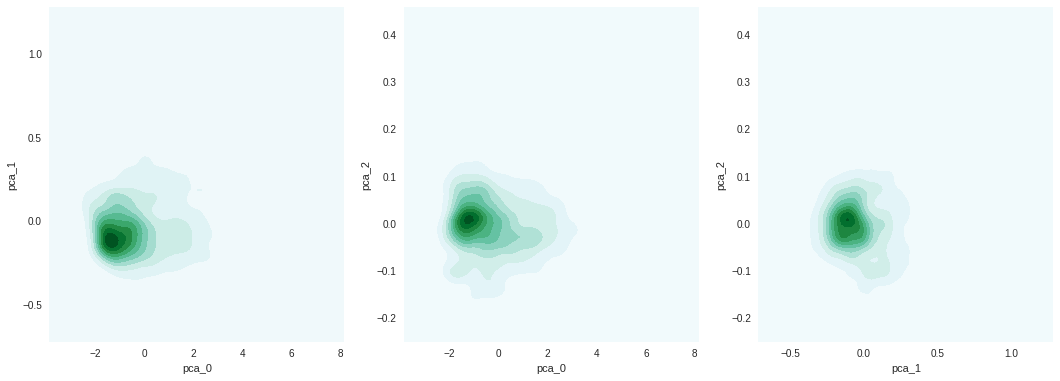

In [8]:
fig, ax = plt.subplots(1, len(axis_combs), figsize=(18, 6))
ax = ax.ravel()

for i, (ax0, ax1) in enumerate(axis_combs):
    #ax[i].scatter(mean_colors[:, ax0], mean_colors[:, ax1], alpha=0.01)
    sns.kdeplot(mean_colors_pca[:, ax0], mean_colors_pca[:, ax1], shade=True, ax=ax[i])
    ax[i].set_xlabel('pca_{}'.format(ax0))
    ax[i].set_ylabel('pca_{}'.format(ax1))

In [9]:
pca.components_

array([[ 0.56644525,  0.58201078,  0.58344085],
       [ 0.68312691,  0.06438623, -0.72745587],
       [ 0.46095271, -0.81062807,  0.36111595]])

In [10]:
pca.explained_variance_

array([ 2.45802842,  0.05178575,  0.00476902])

In [11]:
# From here: https://github.com/Hakuyume/chainercv/blob/master/chainercv/transforms/image/pca_lighting.py
def pca_lighting(img, sigma=0.2, eigen_value=None, eigen_vector=None):
    """AlexNet style color augmentation
    This method adds a noise vector drawn from a Gaussian. The direction of
    the Gaussian is same as that of the principal components of the dataset.
    This method is used in training of AlexNet [1].
    .. [1] Alex Krizhevsky, Ilya Sutskever, Geoffrey E. Hinton. \
    ImageNet Classification with Deep Convolutional Neural Networks. \
    NIPS 2012.
    Args:
        image (numpy.ndarray): An image array to be augmented. This is in
            CHW format.
        sigma (float): Standard deviation of the Gaussian. In the original
            paper, this value is 10% of the range of intensity
            (25.5 if the range is [0, 255]).
        eigen_value: (numpy.ndarray): An array of eigen values. The shape
            have to be (3,). If it is not specified, the values computed from
            ImageNet are used.
        eigen_vector: (numpy.ndarray): An array of eigen vectors. The shape
            have to be (3, 3). If it is not specified, the vectors computed
            from ImageNet are used.
    Returns:
        An image in CHW format.
    """

    if sigma <= 0:
        return img

    # these values are copied from "PCA Colors" notebook
    if eigen_value is None:
        eigen_value = np.array([ 2.59639858,  0.05281296,  0.00470951])
    if eigen_vector is None:
        eigen_vector = np.array(
            [[ 0.56647001,  0.58186674,  0.58356047],
             [ 0.6882782 ,  0.05537043, -0.72333065],
             [ 0.45319405, -0.81139707,  0.3691205 ]])

    alpha = np.random.normal(0, sigma, size=3)

    img = img.copy()
    img += eigen_vector.dot(eigen_value * alpha)

    return img

In [12]:
img = np.r_[load_jpg('train_260'), load_jpg('train_350'), load_jpg('train_450')]

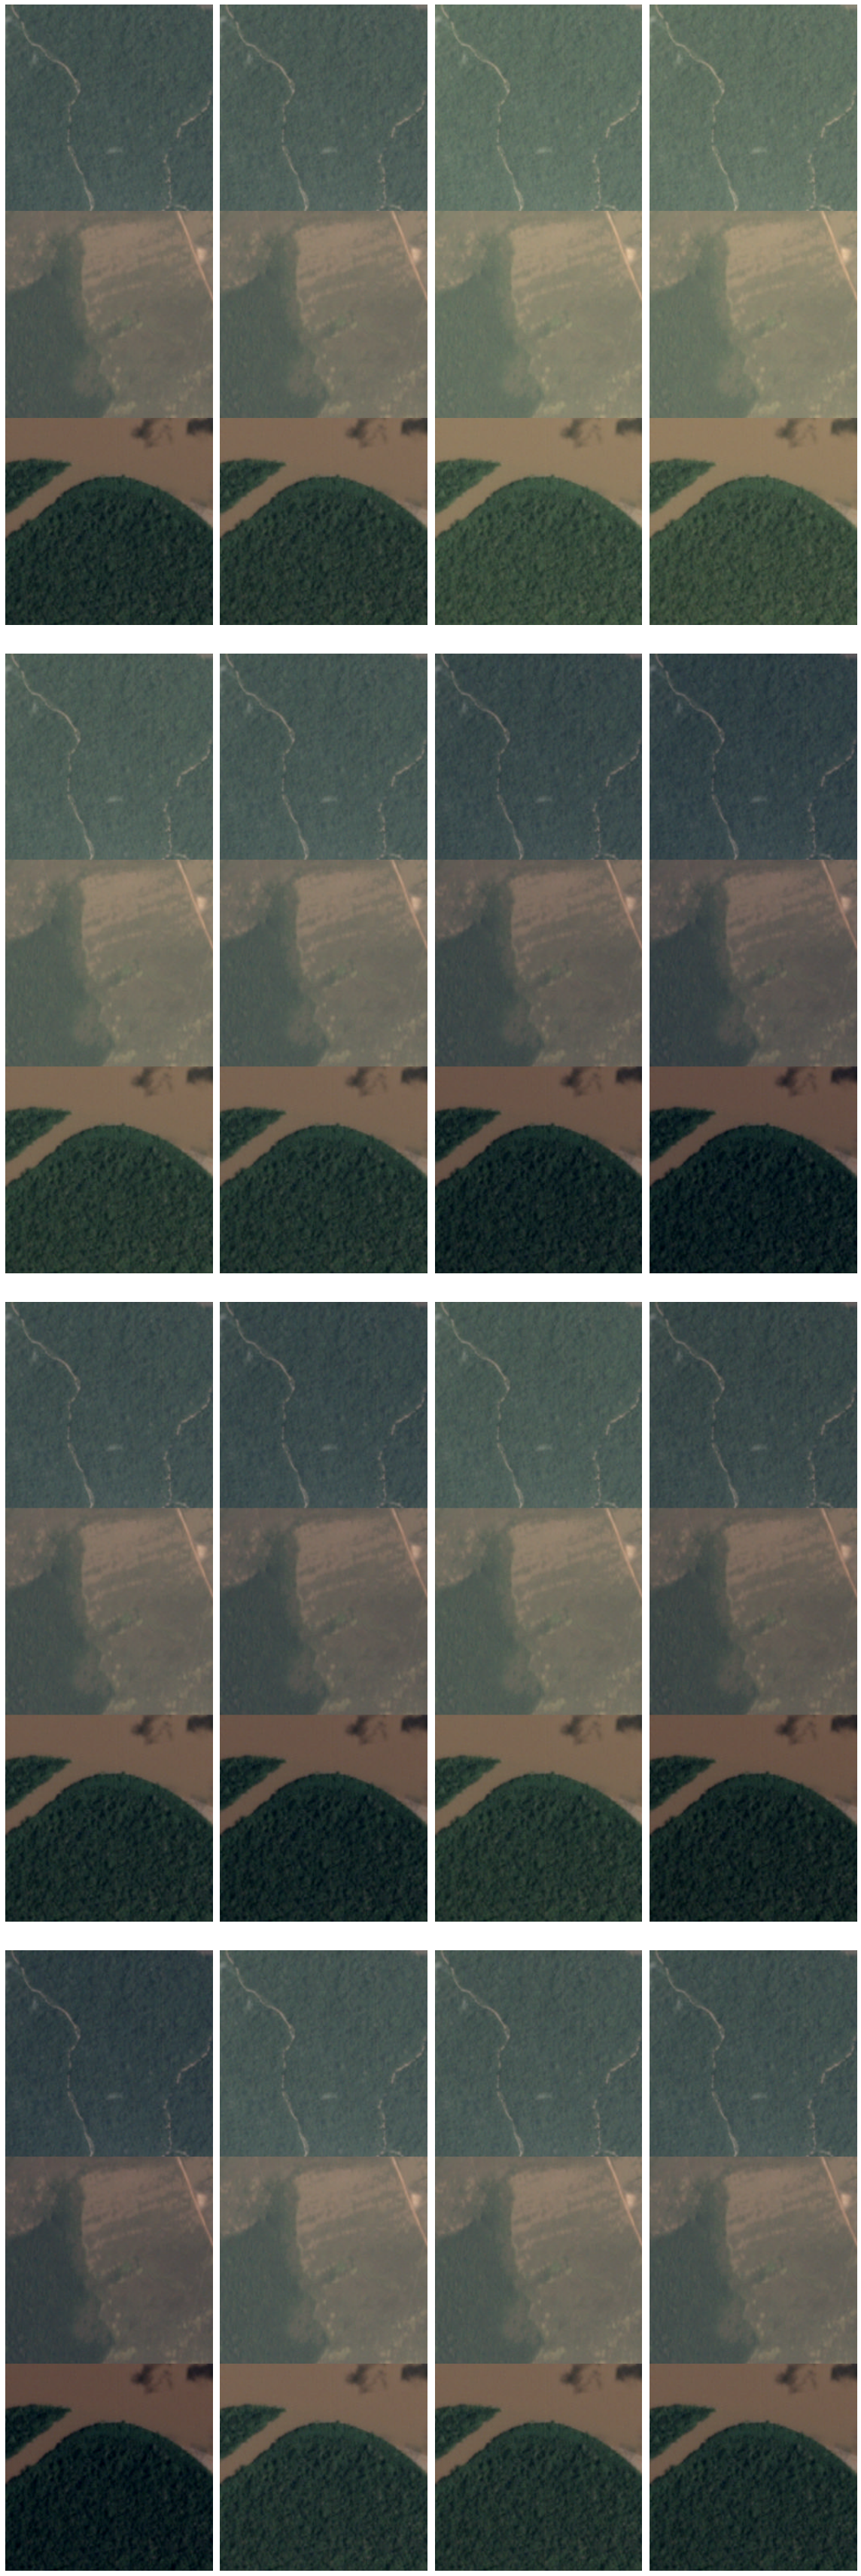

In [13]:
sigma = 0.3 / std_multi

fig, axes = plt.subplots(4, 4, figsize=(16, 48))
axes = axes.ravel()

axes[0].grid(False)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].imshow(denorm(img))

eigen_value = np.array([ 2.59639858,  0.05281296,  0.00470951]) * (std_multi ** 2)

for ax in axes[1:]:
    img2 = pca_lighting(img, sigma, eigen_value=eigen_value)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(denorm(img2))
    
plt.tight_layout()